In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imp
SOURCE_PATH = '../Scripts/'
filterbankio = imp.load_source('filterbankio', SOURCE_PATH + 'filterbankio.py')
FDMT = imp.load_source('FDMT', SOURCE_PATH + 'FDMT.py')

%matplotlib inline

In [2]:
lofarFil = '/local/griffin/data/LOFAR/block39.fil' # aslxlap07

fil = filterbankio.Filterbank(lofarFil)
timeFactor = 64
freqFactor = 8

tInt = fil.header[b'tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0] // timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

### Prep for FDMT

In [3]:
print(waterfall.shape) # (nints, nchan) (nints, nbl, nchan, npol)
spectrogram = np.expand_dims(np.expand_dims(waterfall, axis=1), axis=3)
print(spectrogram.shape)
freqsMHz = freqsHz / 1e6
maxDM = 320.
deltat = 4.15 * maxDM * ((freqsHz[0] / 1e9)**(-2) - (freqsHz[-1] / 1e9)**(-2)) # ms
print('Maximum Dispersion Delay: %f ms'%deltat)
deltatBins = int((deltat / 1e3) / tInt)
print('Integrated bins: %i'%deltatBins)

(512, 1920)
(512, 1, 1920, 1)
Maximum Dispersion Delay: 5004.904488 ms
Integrated bins: 238


In [4]:
# zero pad window to 2**N
log2Shape = int(2**np.ceil(np.log2(spectrogram.shape[2])))
spectrogramPad = np.pad(spectrogram, pad_width=((0,0),(0,0),(0,log2Shape - spectrogram.shape[2]),(0,0)),\
                        mode='median')
print(spectrogramPad.shape)

(512, 1, 2048, 1)


In [5]:
fdmt = FDMT.FDMT(spectrogramPad, freqsMHz[0], freqsMHz[-1], deltatBins, dataType=np.float32)
print(fdmt.shape)

(238, 512, 1, 1)


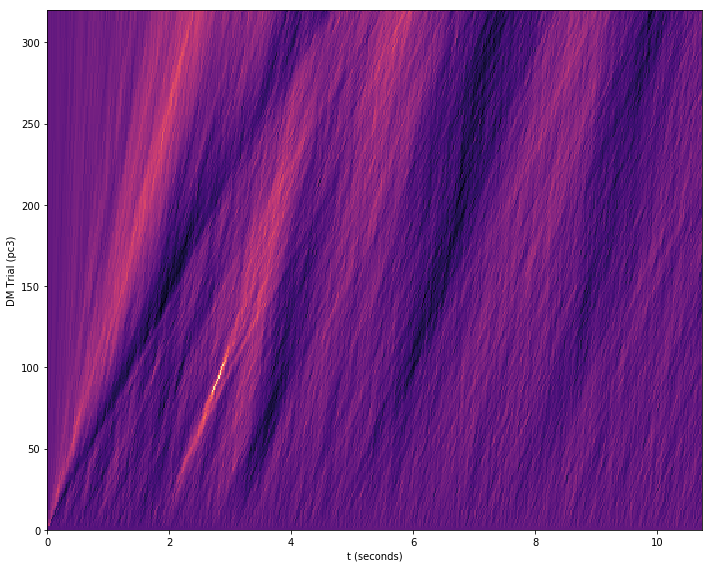

In [6]:
cmap = 'magma'

fig = plt.figure(figsize=(10,8)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=3)
fdmtPlot = plt.imshow(np.flipud(fdmt[:,:,0,0]),\
            extent=(0, tInt*fdmt.shape[1], 0, 320),\
            aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM Trial (pc3)')

plt.xlabel('t (seconds)')

plt.tight_layout()